<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/ALLSUBSTRATES_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

## Uncomment these lines if running as a google colab notebook: 
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
#!pip install numpy==1.15
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [2]:
%load_ext autoreload
%autoreload 2   

In [3]:
#helper utilities for model training and interpretation 
import shap
import sys 
sys.path.append('..')

from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost



## Train AJUBA & TTYH2, Predict NEIL1 <a name='outline'>


In [4]:
data_neil_comp=pd.read_csv("../../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
data_neil_comp=data_neil_comp[~data_neil_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_neil_comp=format_for_xgboost(data_neil_comp)
test_split=data_neil_comp

(434, 202)


In [5]:
data_ajuba_comp=pd.read_csv("../../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
data_ajuba_comp=data_ajuba_comp[~data_ajuba_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_ajuba_comp=format_for_xgboost(data_ajuba_comp)
random.seed(1234)
np.random.seed(1234)
train_split1,eval_split1=split_train_eval_by_mut_pos(data_ajuba_comp[~data_ajuba_comp['mut_pos'].isna()])
null_mut_pos=data_ajuba_comp[data_ajuba_comp['mut_pos'].isna()]
train_split1=pd.concat((train_split1,null_mut_pos),axis=0)

(482, 195)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 44}


In [6]:
data_ttyh2_comp=pd.read_csv("../../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
data_ttyh2_comp=data_ttyh2_comp[~data_ttyh2_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_ttyh2_comp=format_for_xgboost(data_ttyh2_comp)
random.seed(1234)
np.random.seed(1234)
train_split2,eval_split2=split_train_eval_by_mut_pos(data_ttyh2_comp[~data_ttyh2_comp['mut_pos'].isna()])
null_mut_pos=data_ttyh2_comp[data_ttyh2_comp['mut_pos'].isna()]
train_split2=pd.concat((train_split2,null_mut_pos),axis=0)

(601, 205)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 36}


In [7]:
#concatenate train/eval splits from Neil1 & TTYH2 
train_split=pd.concat((train_split1,train_split2),axis=0)
eval_split=pd.concat((eval_split1,eval_split2),axis=0)

In [8]:
train_split.reset_index(inplace=True, drop=True) 
eval_split.reset_index(inplace=True,drop=True)
test_split.reset_index(inplace=True,drop=True)

In [9]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [10]:
#Remove any null features 
train_null=get_high_missingness_features(train_split)
eval_null=get_high_missingness_features(eval_split)
test_null=get_high_missingness_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [11]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d2_5prm_cp_internal:U:A
d1_length_hairpin
d1_struct:S
u1_5prm_cp_bulge:C:G
u3_3prm_cp_internal:G:C
u3_5prm_cp_hairpin
u3_length
site_prev_struct:B
d1_length_internal_ecs
d3_5prm_cp_bulge:G:C
d2_length_hairpin
d2_length_stem
d2_length_bulge
mut_next_struct:H
u3_3prm_cp_internal:G:U
u1_distance
u2_3prm_cp_bulge:G:C
u1_length_bulge
u3_5prm_cp_internal:A:U
d3_exist
u1_length_internal_ecs
d2_5prm_cp_bulge:U:G
site_length_hairpin
u3_5prm_cp_internal:U:A
site_3prm_cp_bulge:A:U
site_3prm_cp_internal:G:U
d1_struct:I
u2_3prm_cp_bulge:U:G
u2_length_hairpin
site_next_struct:S
u1_5prm_cp_internal
u3_length_stem
u2_length_internal_es
mut_prev_struct:H
site_next_struct:B
u3_5prm_cp_internal:G:C
d3_3prm_cp_bulge
d2_5prm_cp_bulge:A:U
u2_5prm_cp_bulge:U:A
d2_struct:S
u3_5prm_cp_bulge
u3_3prm_cp_internal
u1_3prm_cp_bulge
u1_exist
d1_5prm_cp_internal:C:G
d3_length_internal_ecs
u2_3prm_cp_internal:G:U
d1_length_bulge
d2_3prm_cp_internal:A:U
d3_5prm_cp_internal
d1_exist
site_length_bulge
u2_5prm_cp_internal

In [12]:
#remove teh features that don't change across isoforms , or are null for all isoforms
for cur_to_drop in to_drop: 
    try:
        train_split=train_split.drop(cur_to_drop,axis=1)
    except: 
        pass
    try:
        eval_split=eval_split.drop(cur_to_drop,axis=1)
    except: 
        pass 
    try:
        test_split=test_split.drop(to_drop,axis=1)
    except: 
        pass

In [13]:

train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)
eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)
test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [14]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(871, 103)
(871,)
(172, 103)
(172,)
(434, 201)
(434,)


In [15]:
train_cols=set(train_X.columns)
eval_cols=set(eval_X.columns)
test_cols=set(test_X.columns)


In [16]:
common=train_cols.intersection(eval_cols)
common=common.intersection(test_cols)
common=list(common)
#print(common)
train_X=train_X[common]
eval_X=eval_X[common]
test_X=test_X[common]
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(871, 90)
(871,)
(172, 90)
(172,)
(434, 90)
(434,)


In [17]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [18]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [19]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [20]:
num_round = 1000
random.seed(1234)
np.random.seed(1234)
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-aucpr:0.23614	eval-auc:0.79404	eval-mae:0.30361	eval-map:1.00000	eval-rmse:0.31541	train-aucpr:0.28930	train-auc:0.78045	train-mae:0.27708	train-map:1.00000	train-rmse:0.29078
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-aucpr:0.26948	eval-auc:0.80781	eval-mae:0.21952	eval-map:1.00000	eval-rmse:0.23022	train-aucpr:0.30311	train-auc:0.79265	train-mae:0.19601	train-map:1.00000	train-rmse:0.20751
[2]	eval-aucpr:0.23911	eval-auc:0.80069	eval-mae:0.16136	eval-map:1.00000	eval-rmse:0.17270	train-aucpr:0.30941	train-auc:0.79740	train-mae:0.13920	train-map:1.00000	train-rmse:0.14935
[3]	eval-aucpr:0.24172	eval-auc:0.80562	eval-mae:0.12236	eval-map:1.00000	eval-rmse:0.13418	train-aucpr:0.31186	train-auc:0.80054	train-mae:0.10027	train-map:1.00000	train-rmse:0.10909
[4]	eval-aucpr:0.24466	eval-auc:0.81222	eval-mae:0.09535	eval-map:1.00000	eval-rmse:0.10725	train-aucpr:0.31894	tra

[44]	eval-aucpr:0.29059	eval-auc:0.83912	eval-mae:0.02519	eval-map:1.00000	eval-rmse:0.04490	train-aucpr:0.33306	train-auc:0.82293	train-mae:0.00455	train-map:1.00000	train-rmse:0.00659
[45]	eval-aucpr:0.28993	eval-auc:0.83904	eval-mae:0.02511	eval-map:1.00000	eval-rmse:0.04489	train-aucpr:0.33308	train-auc:0.82294	train-mae:0.00447	train-map:1.00000	train-rmse:0.00648
[46]	eval-aucpr:0.29001	eval-auc:0.83909	eval-mae:0.02511	eval-map:1.00000	eval-rmse:0.04492	train-aucpr:0.33310	train-auc:0.82296	train-mae:0.00435	train-map:1.00000	train-rmse:0.00636
[47]	eval-aucpr:0.29038	eval-auc:0.83924	eval-mae:0.02498	eval-map:1.00000	eval-rmse:0.04481	train-aucpr:0.33312	train-auc:0.82298	train-mae:0.00425	train-map:1.00000	train-rmse:0.00621
[48]	eval-aucpr:0.29037	eval-auc:0.83925	eval-mae:0.02494	eval-map:1.00000	eval-rmse:0.04476	train-aucpr:0.33312	train-auc:0.82299	train-mae:0.00415	train-map:1.00000	train-rmse:0.00612
[49]	eval-aucpr:0.29098	eval-auc:0.83936	eval-mae:0.02488	eval-map:1.0

[89]	eval-aucpr:0.29186	eval-auc:0.84021	eval-mae:0.02409	eval-map:1.00000	eval-rmse:0.04410	train-aucpr:0.33346	train-auc:0.82348	train-mae:0.00149	train-map:1.00000	train-rmse:0.00220
[90]	eval-aucpr:0.29187	eval-auc:0.84022	eval-mae:0.02408	eval-map:1.00000	eval-rmse:0.04410	train-aucpr:0.33346	train-auc:0.82348	train-mae:0.00148	train-map:1.00000	train-rmse:0.00218
[91]	eval-aucpr:0.29186	eval-auc:0.84021	eval-mae:0.02407	eval-map:1.00000	eval-rmse:0.04409	train-aucpr:0.33346	train-auc:0.82349	train-mae:0.00147	train-map:1.00000	train-rmse:0.00217
[92]	eval-aucpr:0.29186	eval-auc:0.84023	eval-mae:0.02407	eval-map:1.00000	eval-rmse:0.04407	train-aucpr:0.33346	train-auc:0.82349	train-mae:0.00144	train-map:1.00000	train-rmse:0.00213
[93]	eval-aucpr:0.29186	eval-auc:0.84022	eval-mae:0.02404	eval-map:1.00000	eval-rmse:0.04406	train-aucpr:0.33346	train-auc:0.82349	train-mae:0.00140	train-map:1.00000	train-rmse:0.00209
[94]	eval-aucpr:0.29186	eval-auc:0.84022	eval-mae:0.02403	eval-map:1.0

In [21]:
# save to binary file for faster loading
bst.save_model('cross.substrate.train.neil1.and.ttyh2.substrates.model')
# save model to text file 
bst.dump_model('cross.substrate.train.neil1.and.ttyh2.substrates.txt')


In [22]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [23]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.07)

Train
	Spearman corr : SpearmanrResult(correlation=0.9994367286912034, pvalue=0.0)
	Pearson corr : (0.9999160761893479, 0.0)
	MAE : 0.0010796397405911957
	MAPE : 0.020363990073305884
	RMSE : 0.0015779148511986256
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.8656291024905167, pvalue=5.9429086407908745e-53)
	Pearson corr : (0.9202114019298233, 3.727119602942036e-71)
	MAE : 0.02399357218834027
	MAPE : 0.5724470390034254
	RMSE : 0.043998915303282794
	auPRC : 0.9530829910386586
	auROC : 0.9851621808143548
Test
	Spearman corr : SpearmanrResult(correlation=0.47027692858948195, pvalue=2.890096128454972e-25)
	Pearson corr : (0.532568309645351, 3.6718618105644614e-33)
	MAE : 0.20385196443526976
	MAPE : 0.9422442231477096
	RMSE : 0.2716647043338663
	auPRC : 0.840747089960594
	auROC : 0.7139150019584802


In [24]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9994367286912034, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8656291024905167, pvalue=5.9429086407908745e-53)
Test:SpearmanrResult(correlation=0.47027692858948195, pvalue=2.890096128454972e-25)


Pearson correlation:
Train:(0.9999160761893479, 0.0)
Eval:(0.9202114019298233, 3.727119602942036e-71)
Test:(0.532568309645351, 3.6718618105644614e-33)


In [25]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0010796397405911957
MAE Eval:0.02399357218834027
MAE Test:0.20385196443526976


In [26]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.0363990073305884%
MAPE Eval:57.24470390034254%
MAPE Test:94.22442231477096%


In [27]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0015779148511986256
RMSE Eval:0.043998915303282794
RMSE Test:0.2716647043338663


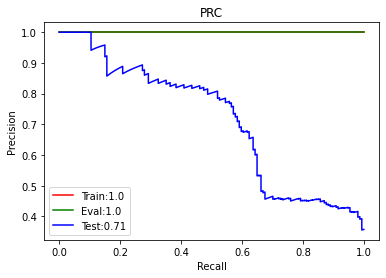

In [28]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.4,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.4,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.4,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

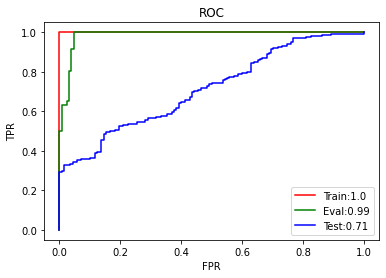

In [29]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.07,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.07,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.07,test_pred)

auroc_train=roc_auc_score(train_y>=0.07,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.07,eval_pred)
auroc_test=roc_auc_score(test_y>=0.07,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [30]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.10899899
37.926343380268996
32.02994282607025
The R-square of the test data is  0.155 



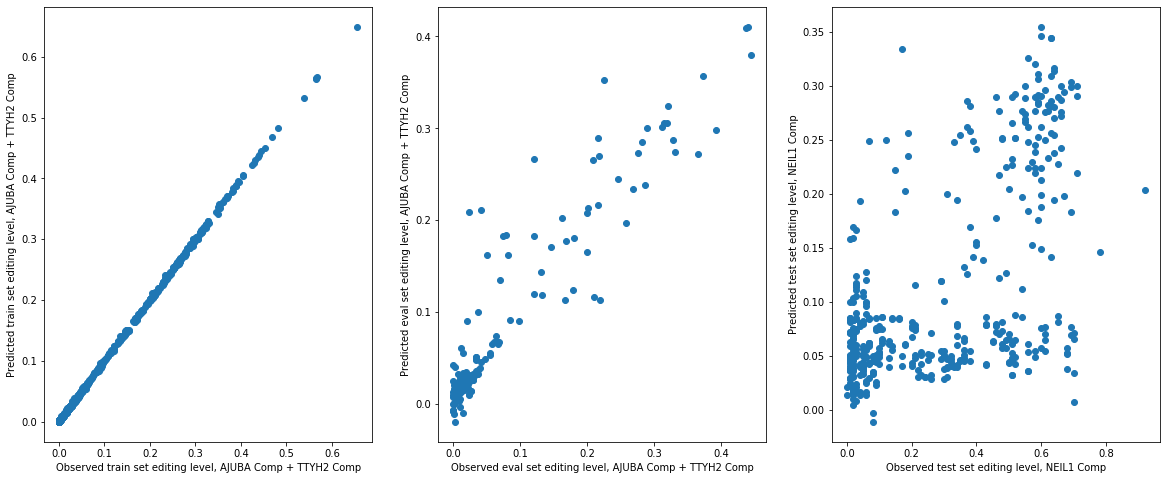

In [38]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, AJUBA Comp + TTYH2 Comp")
plt.ylabel("Predicted train set editing level, AJUBA Comp + TTYH2 Comp")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, AJUBA Comp + TTYH2 Comp")
plt.ylabel("Predicted eval set editing level, AJUBA Comp + TTYH2 Comp")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, NEIL1 Comp")
plt.ylabel("Predicted test set editing level, NEIL1 Comp")

plt.show()

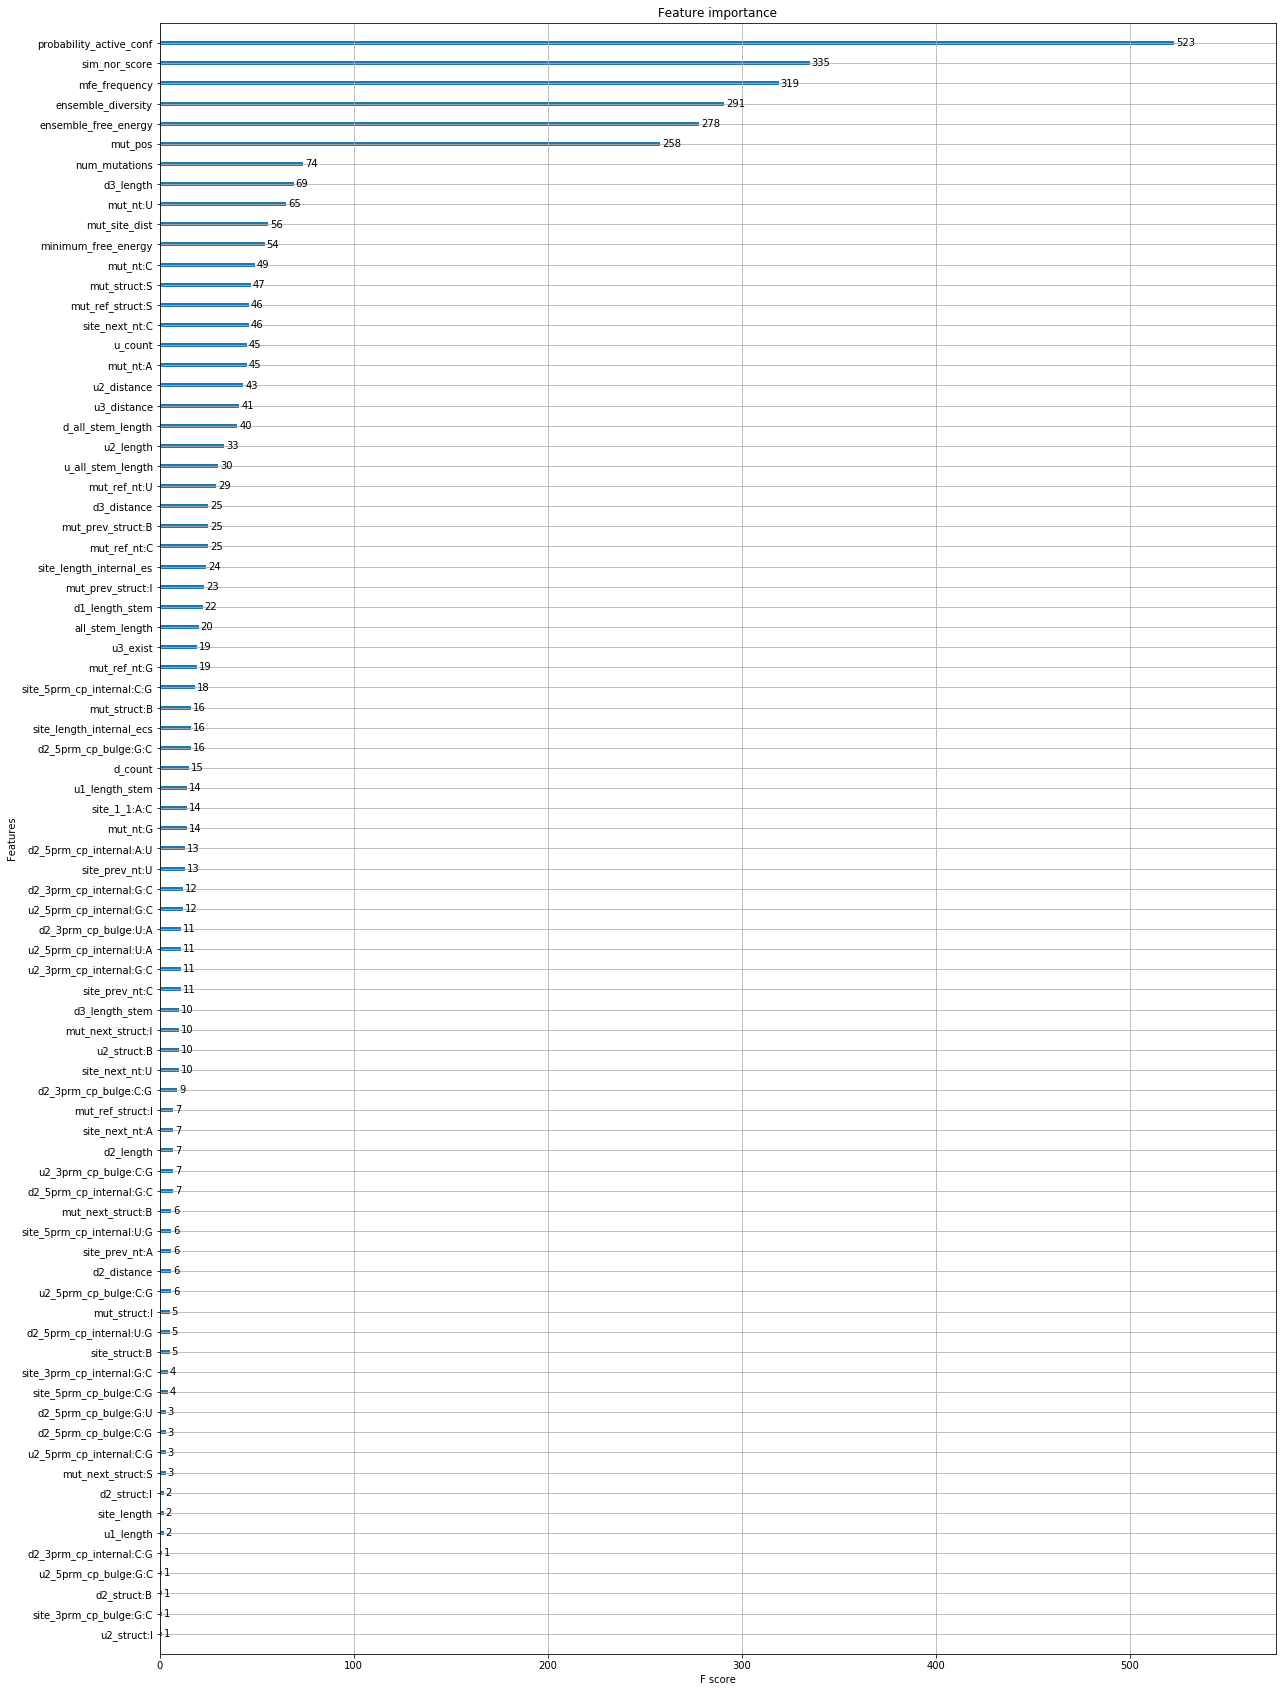

In [39]:
matplotlib.rcParams['figure.figsize'] = [20, 30]
xgboost.plot_importance(bst)

In [34]:
#xgboost.to_graphviz(bst, num_trees=2)


In [35]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(428, 143)

In [36]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [37]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [38]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

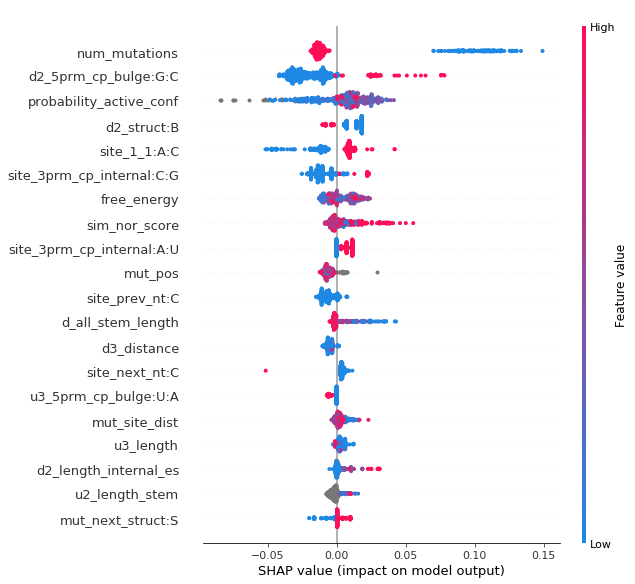

In [39]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


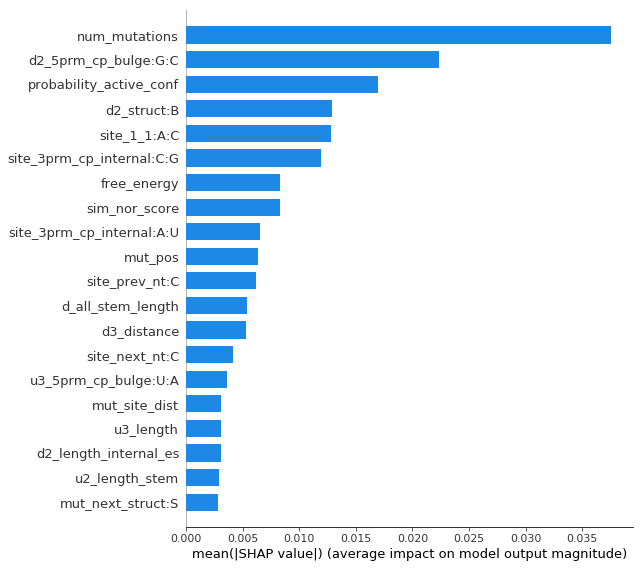

In [40]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [41]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(428, 143, 143)

In [42]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [43]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [44]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
